In [1]:
import pandas as pd
import numpy as np
import nltk
import regex
import collections, re
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer 
from sklearn.cluster import KMeans
from tqdm import tqdm
from gensim.models import Word2Vec 
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.cluster import AffinityPropagation
from sklearn.manifold import TSNE
import spacy
from sklearn.preprocessing import normalize

In [ ]:
def preprocess(df, colname):
    #colname = str(colname)
    #convert to lowercase
    df[colname] = df[colname].apply(lambda x: " ".join(str(x).lower() for x in str(x).split()))
    #remove punctuations
    df[colname] = df[colname].str.replace('[^\w\s]','')
    #remove stopwords
    stop = stopwords.words('english')
    df[colname] = df[colname].apply(lambda x: " ".join(x for x in str(x).split() if x not in stop))
    #remove common words
    freq = pd.Series(' '.join(df[colname]).split()).value_counts()[:10]
    freq = list(freq.index)
    df[colname] = df[colname].apply(lambda x: " ".join(x for x in str(x).split() if x not in freq))
    #remove rare words
    rare = pd.Series(' '.join(df[colname]).split()).value_counts()[-10:]
    rare = list(rare.index)
    df[colname] = df[colname].apply(lambda x: " ".join(x for x in str(x).split() if x not in freq))
    return df

In [30]:
corpus = pd.read_csv('corpus-refined-features.csv')
corpus.head()

,Unnamed: 0,index,Avg_sent,Descriptors,Freq
0,0,ippt,0.857268,"here ,took ,take ,take ,take ,needs ,ffi ,appl...",1052
1,2,ipt,0.860323,"take ,perform ,put ,go ,take ,take ,take ,try ...",570
2,3,sessions,0.867581,"screening ,do ,do ,have ,attend ,attend ,atten...",462
3,4,still,0.857143,"it ,you",449
4,5,rt,0.852987,"attend ,take ,do ,do ,u ,complete ,complete ,w...",434


In [116]:
corpus['index' == 'dec']

KeyError: False

In [91]:
test_before = corpus['index']
#test = np.asarray(test)
test_before

0           ippt
1            ipt
2       sessions
3          still
4             rt
          ...   
1766        vary
1767     mailbox
1768      forsee
1769        save
1770         win
Name: index, Length: 1771, dtype: object

In [32]:
test[0:3]

0        ippt
1         ipt
2    sessions
Name: index, dtype: object

In [84]:
#import spacy
nlp = spacy.load("en_core_web_sm")
#nlp = spacy.blank("en")
#nlp = spacy.load("en_core_web_lg")

In [90]:
nlp.Defaults.stop_words

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'fron

In [92]:
test = [item for item in test_before if item not in nlp.Defaults.stop_words]
len(test)

1719

In [124]:
from nltk.stem import PorterStemmer
Stem_words = []
ps =PorterStemmer()
for w in test:
    rootWord=ps.stem(w)
    if rootWord not in Stem_words:
        Stem_words.append(rootWord)

In [125]:
len(Stem_words)

1402

In [126]:
X2 = normalize(np.stack(vectorize(t) for t in Stem_words))
X3 = np.stack(vectorize(t) for t in Stem_words)

c:\python38\lib\site-packages\IPython\core\interactiveshell.py:3357: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):
c:\python38\lib\site-packages\IPython\core\interactiveshell.py:3357: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [127]:
affprop = AffinityPropagation()
affprop.fit(X2)
for cluster_id in np.unique(affprop.labels_):
    exemplar = t[affprop.cluster_centers_indices_[cluster_id]]
    cluster = np.unique(t[np.nonzero(affprop.labels_==cluster_id)])
    cluster_str = ", ".join(cluster)
    print(" - *%s:* %s" % (exemplar, cluster_str))

c:\python38\lib\site-packages\sklearn\cluster\_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(


 - *fit:* fit, march
 - *im:* age, airforce, alrdy, appropriate, background, clock, close, control, duration, focus, garang, got, happy, highlight, hold, huh, im, khatib, lessons, makan, mark, palms, perform, plenty, pop, pressure, religious, reservists, scholarships, search, servicemen, sessions, sf, siao, sit, slippers, staff, supply, timing, virus, weird, wish, ya
 - *simple:* attain, batch, congrats, night, penalty, probably, simple, specs, update, useless, welcome
 - *mindef:* attend, bedok, bros, clear, cleared, fr, good, mindef, mo, month, people, safra, thank, time
 - *push:* asa, change, counter, covid, defer, guardroom, inpro, knows, la, mc, mri, new, obligations, okay, oot, push, sat, serve, sia, speak
 - *early:* area, believe, black, carpark, early, feels, fri, interview, male, males, opens, quota, regimentation, risk, spare, sports, superior, touch, true, university
 - *try:* grow, image, know, mr, reply, thing, try, year
 - *issue:* callup, click, commanders, considerati

In [128]:
affprop = AffinityPropagation()
affprop.fit(X3)
for cluster_id in np.unique(affprop.labels_):
    exemplar = t[affprop.cluster_centers_indices_[cluster_id]]
    cluster = np.unique(t[np.nonzero(affprop.labels_==cluster_id)])
    cluster_str = ", ".join(cluster)
    print(" - *%s:* %s" % (exemplar, cluster_str))

c:\python38\lib\site-packages\sklearn\cluster\_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(


 - *fit:* fit, march, reply
 - *pes:* appointments, big, boots, cancellation, english, games, gold, look, organisations, pes, portal, professional, realise, requirements, salary, systems, tests, wonder, xxx
 - *im:* appropriate, commitments, conditions, control, counter, duration, eat, focus, garang, happy, huh, im, khatib, kit, mark, ones, plenty, pressure, release, religious, reservists, scholarships, search, servicemen, sf, siao, sit, slippers, supply, timing, uni, updates, verifies, weird, wish
 - *simple:* appt, attain, batch, congrats, guardhouse, penalty, probably, simple, specs, update, useless, welcome
 - *cant:* anal, applies, areas, ask, cant, concerns, count, defaulter, fail, funny, ie, indicate, long, manual, moi, mustache, option, order, require, session, sick, sign, special, students, suffer, test, theres, tough, updated, useful, venues, vocation, waiver
 - *mindef:* attend, bedok, bros, clear, good, mindef, mo, month, people, safra, thank, time
 - *close:* book, camera,

In [131]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
lemma_word = []
for w in Stem_words:
    word1 = wordnet_lemmatizer.lemmatize(w, pos = "n")
    word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v")
    word3 = wordnet_lemmatizer.lemmatize(word2, pos = ("a"))
    if word3 not in lemma_word:
        lemma_word.append(word3)

In [132]:
len(lemma_word)

1381

In [133]:
lemma_word[:20]

['ippt',
 'ipt',
 'session',
 'rt',
 'window',
 'book',
 'time',
 'clear',
 'year',
 'dont',
 'n',
 'complet',
 'pas',
 'ict',
 'unit',
 'thank',
 'fit',
 'pe',
 'im',
 'peopl']

In [85]:
def vectorize(text):
    """Get the SpaCy vector corresponding to a text"""
    return nlp(text).vector

In [97]:
X = normalize(np.stack(vectorize(t) for t in test))
X1 = np.stack(vectorize(t) for t in test)

c:\python38\lib\site-packages\IPython\core\interactiveshell.py:3357: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):
c:\python38\lib\site-packages\IPython\core\interactiveshell.py:3357: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [79]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X2 = pca.fit_transform(X)
print("X2 shape is {}".format(X2.shape))

X2 shape is (1771, 2)


In [68]:
CLUSTERS = 75
from sklearn.cluster import KMeans
k_means = KMeans(n_clusters=CLUSTERS, random_state=1)
k_means.fit(X)

KMeans(n_clusters=81, random_state=1)

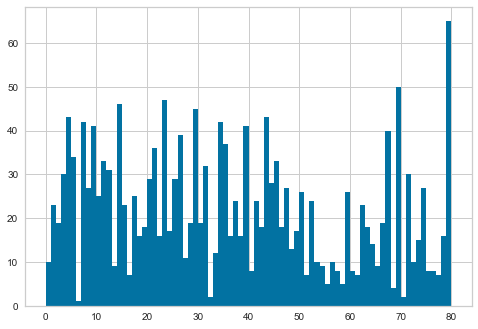

In [69]:
yhat = k_means.predict(X)

# Let's take a look at the distribution across classes
plt.hist(yhat, bins=range(CLUSTERS))
plt.show()

Wordcloud for category #0


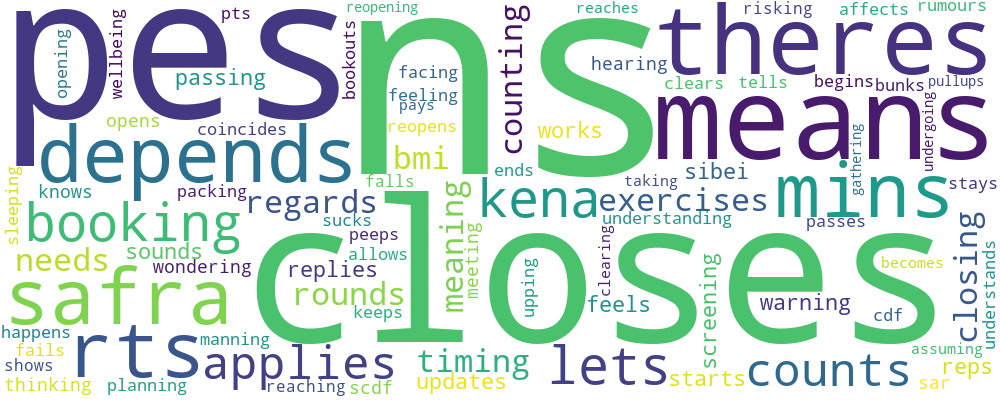

Wordcloud for category #1


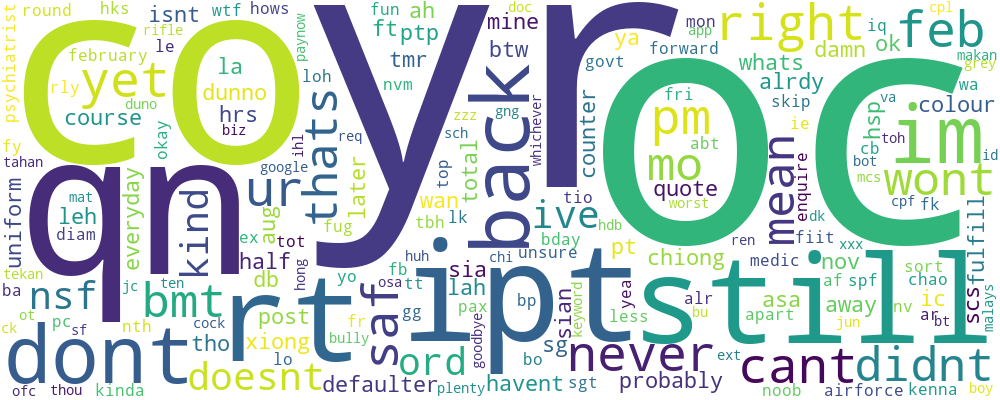

Wordcloud for category #2


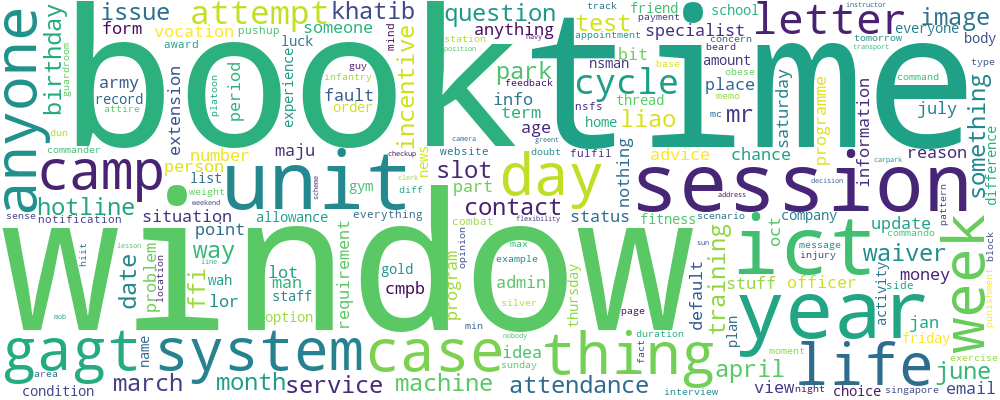

Wordcloud for category #3


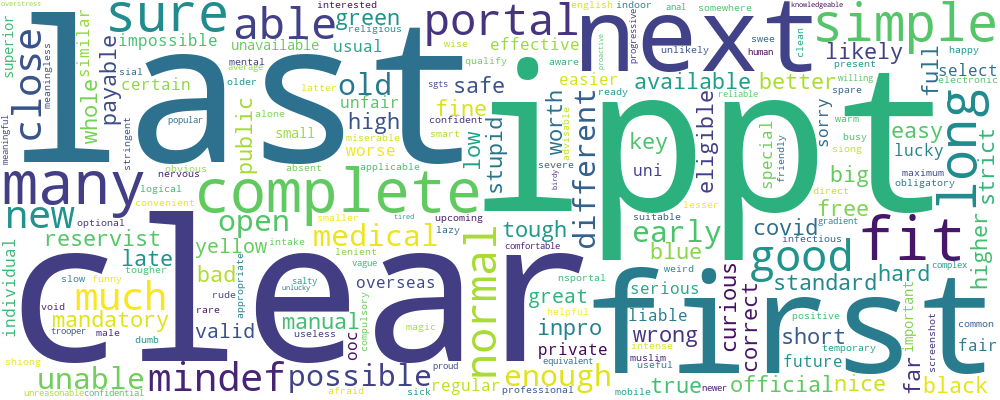

Wordcloud for category #4


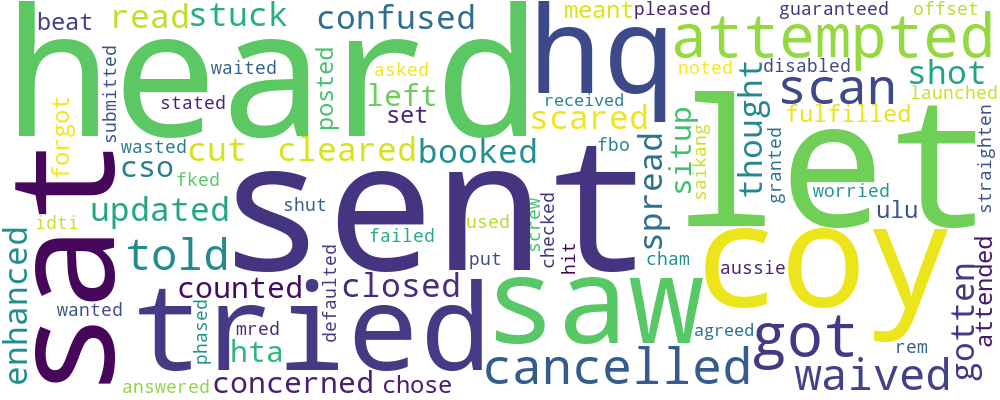

Wordcloud for category #5


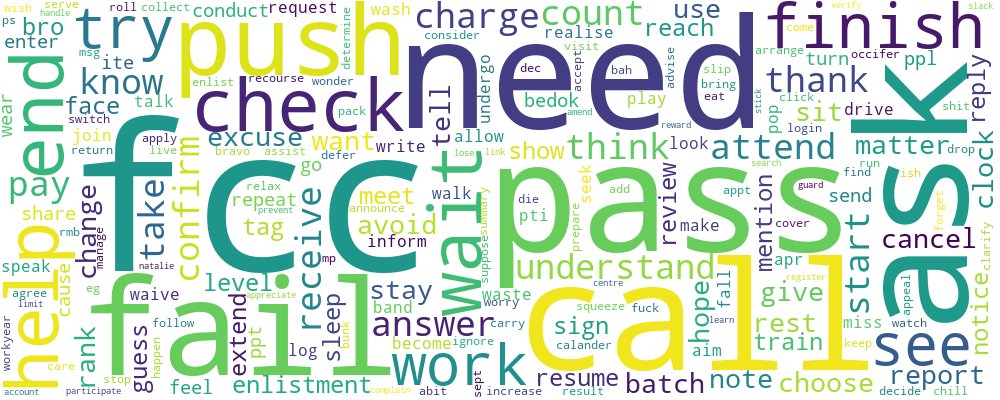

Wordcloud for category #6


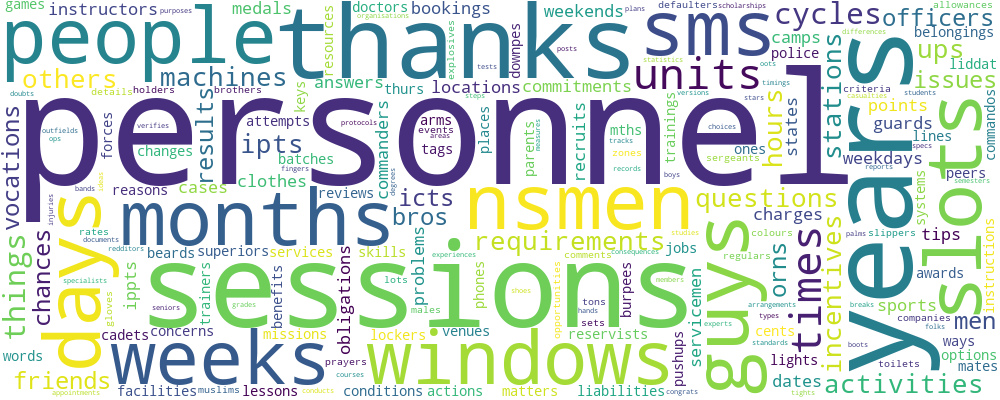

In [59]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
better_stopwords = STOPWORDS.union({'may', 'one', 'will', 'also'})
wc = WordCloud(background_color='white', width=1000, height=400, stopwords=better_stopwords)

for c in range(CLUSTERS):
    print("Wordcloud for category #{}".format(c))
    display(wc.generate(" ".join(test[yhat == c])).to_image())

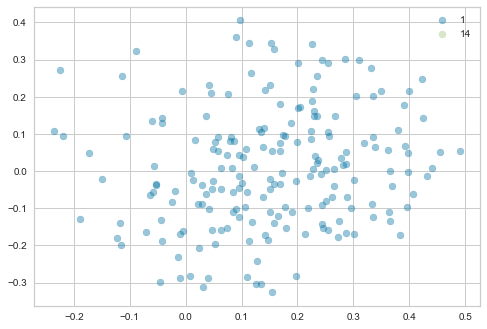

In [60]:
plot_groups(X2, yhat, (1,14))

In [ ]:
word_array=np.array([np.array(xi) for xi in word_vectors])

In [ ]:
type(word_array[0])

In [ ]:
np.array(word_vectors[0:10])

In [ ]:
t = np.array(word_vectors[0:4])

In [115]:
a = nlp(test[0])
b = nlp(test[1])
a.similarity(b)

<ipython-input-115-5b820bf98376>:3: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  a.similarity(b)


0.25468639699632023

In [94]:
X

array([[-0.2218593 ,  0.00333713, -0.07148197, ..., -0.10561418,
         0.07326072, -0.20833896],
       [-0.05724632, -0.07160849,  0.12412028, ..., -0.06075482,
        -0.12286021, -0.18689181],
       [ 0.18745771,  0.02654228,  0.11503202, ...,  0.01264915,
         0.00050406,  0.04852844],
       ...,
       [-0.1486416 , -0.00446677,  0.10941894, ..., -0.00436939,
        -0.04664651, -0.22406232],
       [-0.03063095, -0.08811715,  0.04953791, ...,  0.04136233,
        -0.07241443, -0.21242416],
       [ 0.07832913, -0.03977542,  0.06285173, ...,  0.17200015,
        -0.1040851 , -0.21203178]], dtype=float32)

In [110]:
affprop = AffinityPropagation()
affprop.fit(X1)
for cluster_id in np.unique(affprop.labels_):
    exemplar = t[affprop.cluster_centers_indices_[cluster_id]]
    cluster = np.unique(t[np.nonzero(affprop.labels_==cluster_id)])
    cluster_str = ", ".join(cluster)
    print(" - *%s:* %s" % (exemplar, cluster_str))

c:\python38\lib\site-packages\sklearn\cluster\_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(


 - *dont:* cant, didnt, doesnt, dont, havent, wont
 - *complete:* birdy, clean, clear, complete, correct, exempt, liable, open, qualify, select, sorry, strict, suitable
 - *long:* bully, early, far, hard, kinda, late, long, mcs, nsdotsg, overseas, rly, worst
 - *days:* days, hours, months, thanks, times, ways, weeks, years
 - *good:* advisable, bad, brief, compulsory, cool, curious, dependent, different, dusty, fine, funny, good, great, green, haiz, incamp, mandatory, maximum, meaningful, mindef, miserable, nice, present, proactive, public, regular, right, siong, stringent, tough, true, useless, vague, weird, wrong
 - *week:* april, bit, day, december, hour, july, june, month, night, november, time, way, week, weekend, year
 - *letter:* abuse, background, base, bill, blur, butt, concern, cookhouse, degree, direction, division, dun, experience, eye, factor, fi, force, incident, job, kana, kit, language, letter, mission, mob, moi, mustache, period, prep, privilege, programme, quiz, rate,

In [108]:
affprop = AffinityPropagation(max_iter = 250)
affprop.fit(X)
for cluster_id in np.unique(affprop.labels_):
    exemplar = t[affprop.cluster_centers_indices_[cluster_id]]
    cluster = np.unique(t[np.nonzero(affprop.labels_==cluster_id)])
    cluster_str = ", ".join(cluster)
    print(" - *%s:* %s" % (exemplar, cluster_str))

c:\python38\lib\site-packages\sklearn\cluster\_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(


 - *complete:* absent, akin, birdy, clean, clear, complete, cool, correct, exempt, fit, liable, mindef, open, present, qualify, select, seperate, slow, sorry, spare, strict, suitable, sure, vague, void
 - *im:* im, ive
 - *system:* activation, activity, application, article, bag, bill, boat, car, case, cd, checkup, correction, degree, fee, force, game, guideline, helpdesk, incident, letter, ministry, ndu, number, page, paper, phase, process, program, quiz, requirement, rod, scenario, schedule, site, solution, source, station, status, story, strength, student, system, type, version, website, word, zone
 - *long:* early, far, hard, late, long, mcs, mon, nsdotsg, rly, worst
 - *days:* days, hours, malays, months, ops, pouch, thanks, times, ways, weekdays, weeks, years
 - *week:* april, bit, day, december, hour, june, month, night, november, time, way, week, weekend, year
 - *question:* address, admin, attempt, attitude, chance, consideration, decision, dude, effect, effort, fallout, fix, 

In [105]:
t = [item for item in t if item not in nlp.Defaults.stop_words]
len(t)
ty

1719

In [107]:
type(t)
t = np.asarray(t)

In [66]:
affprop.cluster_centers_indices_

array([  16,   25,   28,   32,   41,   59,   73,  101,  109,  112,  116,
        123,  129,  143,  172,  183,  200,  201,  216,  219,  230,  265,
        301,  310,  336,  338,  429,  449,  486,  489,  507,  575,  589,
        631,  656,  693,  741,  835,  861,  884,  888,  893,  894,  931,
        936,  939,  982,  986,  987, 1004, 1025, 1042, 1080, 1094, 1102,
       1121, 1133, 1142, 1192, 1203, 1209, 1263, 1297, 1314, 1331, 1345,
       1354, 1372, 1403, 1426, 1439, 1445, 1525, 1531, 1548, 1550, 1620,
       1627, 1629, 1729, 1744, 1764], dtype=int64)

## Kmeans

In [42]:
import pandas as pd
import matplotlib as mpl 
import matplotlib.pyplot as plt 

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

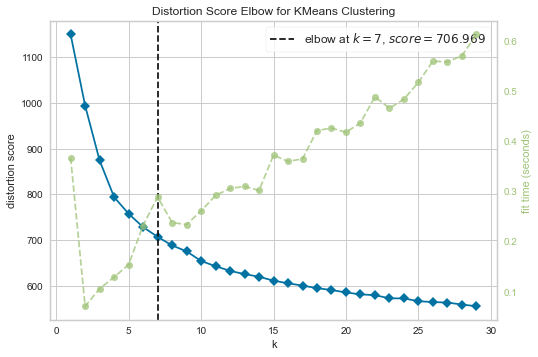

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [56]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,30))

visualizer.fit(X)    # Fit the data to the visualizer
visualizer.poof()